### Compute equilibrium for the no-aggregate uncertainty KS model: DTCSCC

Proof of concept for computing the equilibrium for the model. Then, using the equilibrium aggregate capital, compute the stationary distribution (and decision rules) and plot them. This version uses a dtcscc model, thereby allowing continuous shocks.

This code does not make use of CompEcon, or rely on linear basis matrices. 

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa

from dolo import yaml_import
from dolo.algos.dtcscc.time_iteration import time_iteration, time_iteration_direct
import dolo.algos.dtcscc.distributions_general as dst
# import dolo.algos.dtcscc.distributions as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

Nf = np.array([20, 20])

In [3]:
# filename = 'incomplete_markets_dtcscc_direct.yaml'
# model2 = yaml_import(filename)


### Solve using time iteration and plot decision rules

In [3]:
# Note: time iteration need not converge monotonically. Reasonably slow: 6-7s per loop.
dr = time_iteration(model, with_complementarities=True, verbose=False) 

# Note: time iteration direct is faster: 419ms per loop. But note: direct doesn't seem to work here...
# dr_direct = time_iteration_direct(model2, verbose=False) 

    Maximum number of iterations reached


In [4]:
sgridf = dst.fine_grid(model, Nf)
sprimef = dst.dr_to_sprime(model, dr, Nf)

In [ ]:
grid = model.get_grid()
emin = grid.a[1]
emax = grid.b[1]
rho_e = model.calibration_dict['rho_e']
gtilde = e**rho_e*np.exp(eps)
gtilde = np.minimum(gtilde, emax)
gtilde = np.maximum(gtilde, emin)

In [43]:
# # # ABORTED ATTEMPT TO GET TIME ITERATION DIRECT WORKING

# auxcons = model2.functions['auxiliary']    # aux(s, x, p, out)
# parms = model.calibration['parameters']
# grid = model2.get_grid()
# Nk = grid.orders[0]
# Ne = grid.orders[1]
# grid = grid.grid
# inv = dr_direct(grid)
# cons = auxcons(grid, inv, parms)

# inv = inv.reshape([Nk, Ne])

# %matplotlib inline

# plt.figure(figsize=(10, 10))
# for i_e in range(5):
#     plt.plot(np.unique(grid[:,0]), inv[:,i_e])


# Something really weird about this... Clearly not solving for the correct decision rule


In [147]:
# Nk = 100
# Nftmp = np.array([1, Nk])
# egrid = np.unique(dr_direct.grid[:,0])
# Ne = egrid.shape[0]

# cons_direct = np.zeros([Nk, Ne])
# for i_e in range(Ne):
#     sgridf = mlinspace(np.array([egrid[i_e], min(dr_direct.grid[:,1])]), np.array([egrid[i_e], max(dr_direct.grid[:,1])]),Nftmp)
#     cons_direct[:, i_e] = dr_direct(sgridf).flatten()
# #     cons_direct[:, i_e] = auxcons(sgridf, tmp, parms).flatten()

# # %matplotlib inline

# plt.figure(figsize=(10, 10))
# # plt.plot(sgridf[:,0], dr_direct(sgridf),label='e_0')
# for i_e in range(5):
#     plt.plot(sgridf[:,0], cons_direct[:,i_e],label='e_'+str(i_e))
# plt.ylabel('Consumption, c')
# plt.xlabel('Capital, k')
# plt.title('Consumption function: time iteration')
# plt.legend()
# plt.grid()

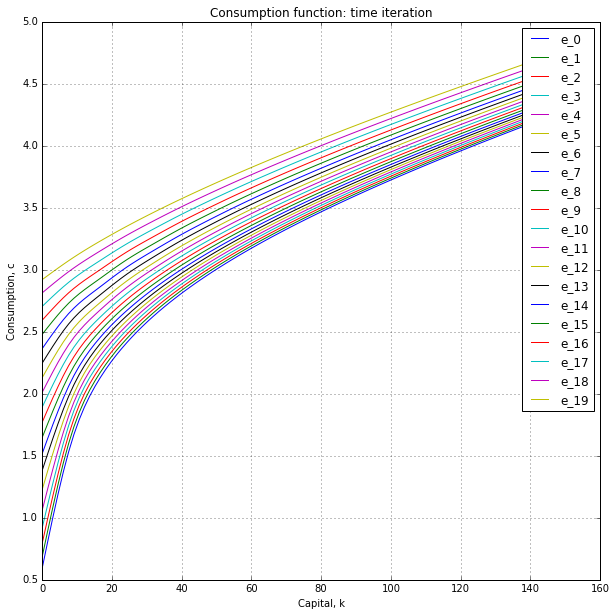

In [4]:
# dr = time_iteration(model, with_complementarities=True, verbose=False) 

Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
# drc_direct = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()
#     drc_direct[:, i_e] = dr_direct(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))

# TECHNOLOGY SHOCK
# plt.subplot(121)
for i_e in range(Nf[1]):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function: time iteration')
plt.legend()
plt.grid()

# plt.subplot(122)
# for i_e in range(5):
#     plt.plot(sgridf[:,0], drc_direct[:,i_e],label='e_'+str(i_e))
# plt.ylabel('Consumption, c')
# plt.xlabel('Capital, k')
# plt.title('Consumption function: time iteration direct')
# plt.legend()
# plt.grid()

### Compute stationary distribution 

In [5]:
L, QT = dst.stat_dist(model, dr, Nf, Nq=7, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.260547 

Iteration = 100, dist = 0.005009 

Iteration = 200, dist = 0.001238 

Iteration = 300, dist = 0.000242 

Iteration = 400, dist = 0.000045 

Iteration = 500, dist = 0.000008 

Iteration = 600, dist = 0.000002 

Iteration = 700, dist = 0.000000 

Iteration = 800, dist = 0.000000 

Iteration = 900, dist = 0.000000 



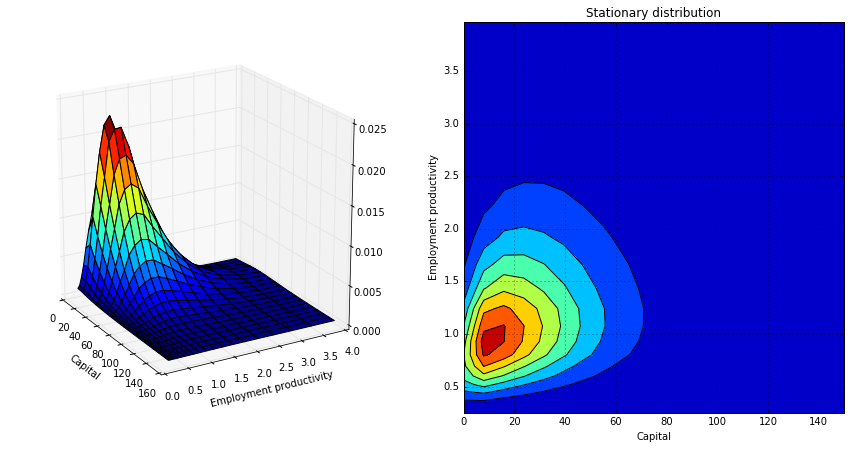

In [32]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf])
kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, egridf)

fig = plt.figure(figsize=(15, 7))
# plt.subplot(121)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X,np.exp(Y),Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 330

ax = fig.add_subplot(122)
contour = plt.contour(X, np.exp(Y), Z, colors='k')
cp = plt.contourf(X, np.exp(Y), Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()

In [33]:
Kd, Ks, r = dst.supply_demand(model, Nf, numpoints=30, lower=40, upper=50, verbose=True)

    Maximum number of iterations reached


Iteration = 0

Iteration = 1

Iteration = 2

Iteration = 3

Iteration = 4

Iteration = 5

Iteration = 6

Iteration = 7

Iteration = 8

Iteration = 9

Iteration = 10

Iteration = 11

Iteration = 12

Iteration = 13

Iteration = 14

Iteration = 15

Iteration = 16

Iteration = 17

Iteration = 18

Iteration = 19

Iteration = 20

Iteration = 21

Iteration = 22

Iteration = 23

Iteration = 24

Iteration = 25

Iteration = 26

Iteration = 27

Iteration = 28

Iteration = 29



(20, 70)

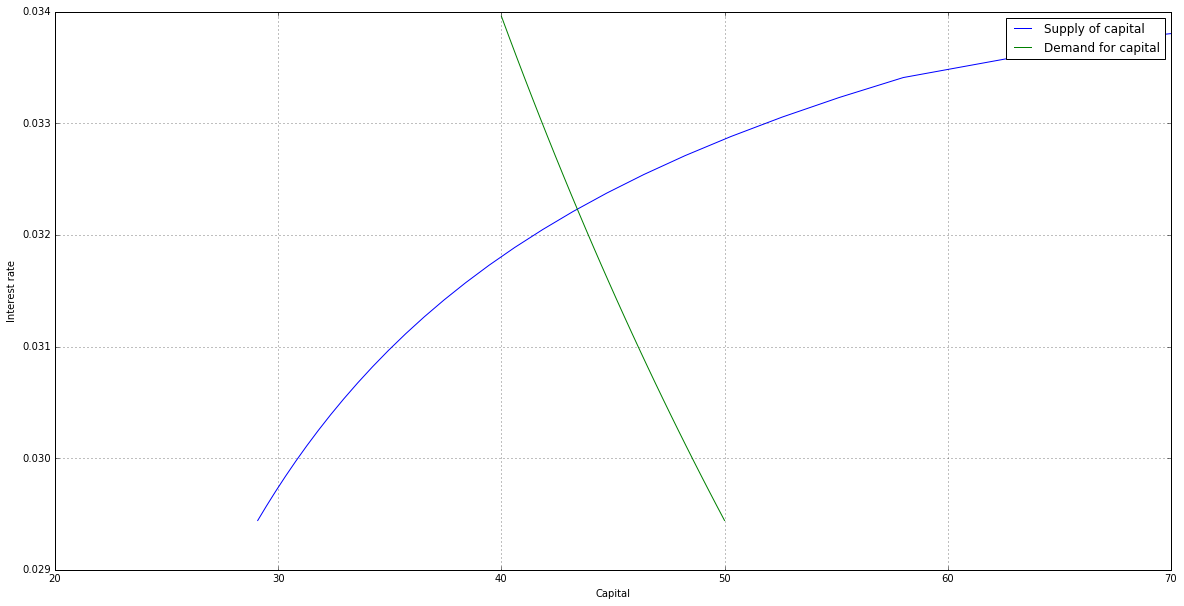

In [36]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
# plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
# plt.ylim(0.027, 0.034)
plt.xlim(20, 70)

### Compute the equilibrium interest rate 

Note: there was previously a problem with the equilibrium interest rate being different from the answer in matlab. I've resolved this now, as it was due to a confusion over the correct moment to use in constructing the Gauss Hermite quadrature nodes for computing expectations. 

In [35]:
K = dst.solve_eqm(model, Nf, Kinit=40, tolKeq=1e-4, verbose=True)

    Maximum number of iterations reached


Iteration = 	0: K=	40.0000  Kagg=	77.3404

Iteration = 	1: K=	40.0373  Kagg=	68.2802

Iteration = 	2: K=	40.2067  Kagg=	66.3045

Iteration = 	3: K=	40.4928  Kagg=	65.9429

Iteration = 	4: K=	40.8977  Kagg=	60.3661

Iteration = 	5: K=	41.3033  Kagg=	56.2369

Iteration = 	6: K=	41.6875  Kagg=	52.8385

Iteration = 	7: K=	42.0287  Kagg=	50.6585

Iteration = 	8: K=	42.3345  Kagg=	48.6863

Iteration = 	9: K=	42.5903  Kagg=	47.3027

Iteration = 	10: K=	42.8027  Kagg=	46.1649

Iteration = 	11: K=	42.9703  Kagg=	45.3451

Iteration = 	12: K=	43.0999  Kagg=	44.7380

Iteration = 	13: K=	43.1971  Kagg=	44.2976

Iteration = 	14: K=	43.2675  Kagg=	43.9958

Iteration = 	15: K=	43.3176  Kagg=	43.7683

Iteration = 	16: K=	43.3506  Kagg=	43.6261

Iteration = 	17: K=	43.3721  Kagg=	43.5344

Iteration = 	18: K=	43.3855  Kagg=	43.4775

Iteration = 	19: K=	43.3935  Kagg=	43.4436

Iteration = 	20: K=	43.3981  Kagg=	43.4242

Iteration = 	21: K=	43.4006  Kagg=	43.4136

Iteration = 	22: K=	43.4019  Kagg=	43.4081

### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [4]:
# Set model calibration to the equilibrium aggregate capital stock.
model.set_calibration(kagg=K)

# drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [5]:
L, QT = dst.stat_dist(model, mdr, Nkf=Nkf, verbose=False)

### Plot the equilibrium stationary distribution and decision rules

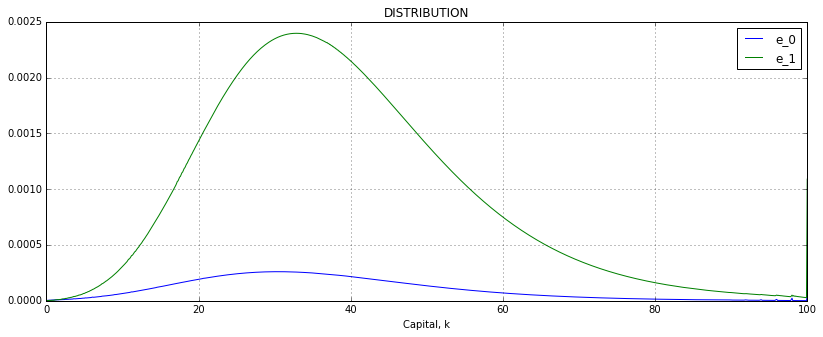

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

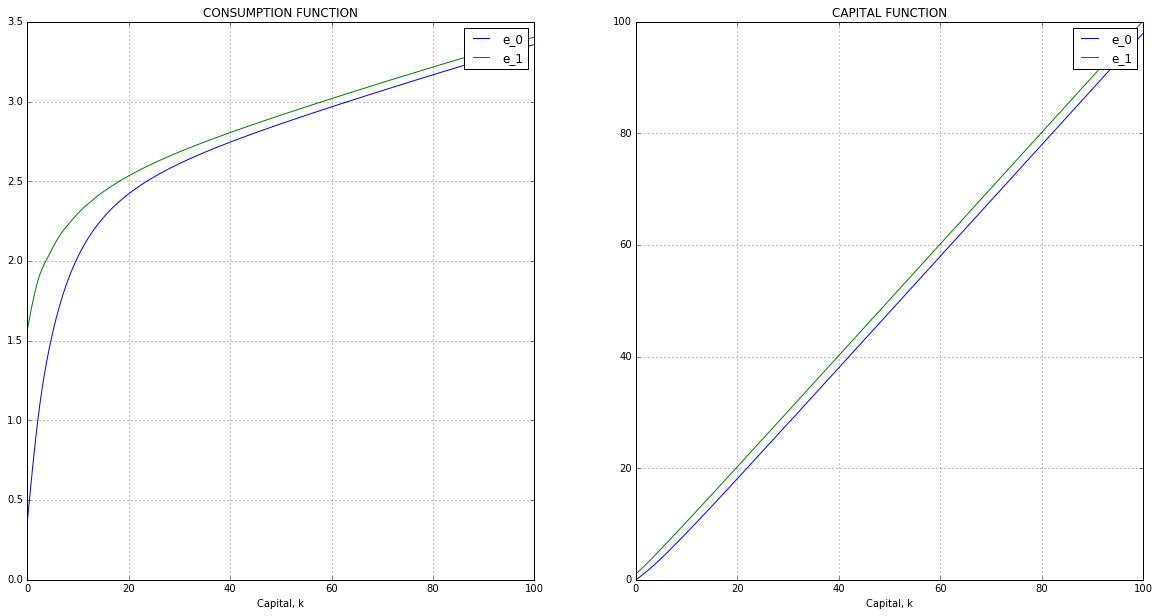

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

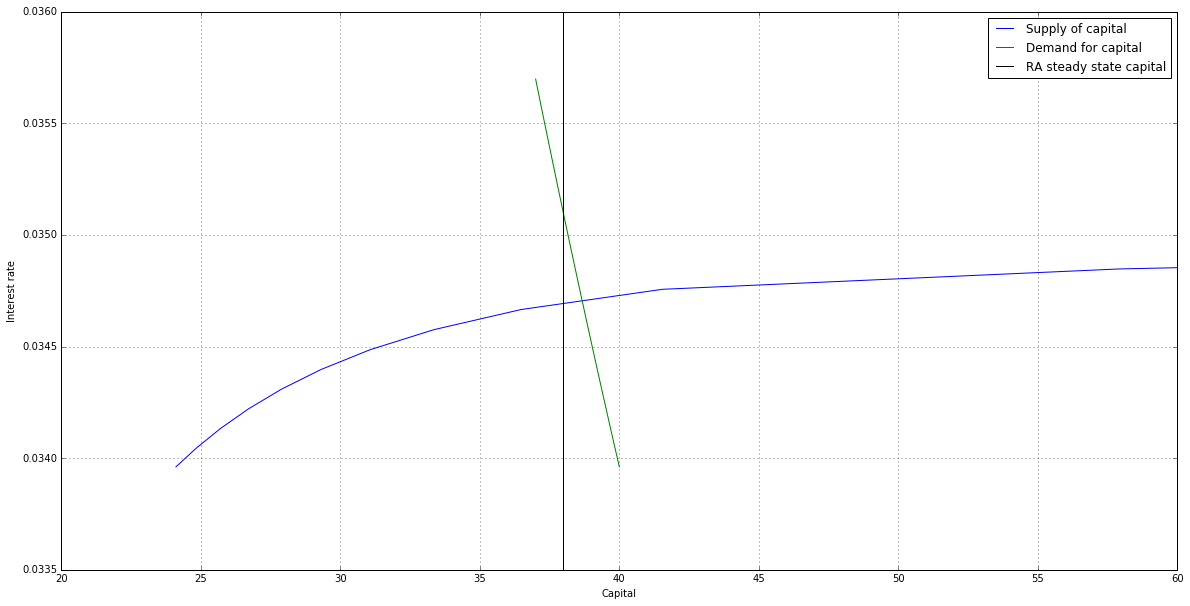

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 